<a href="https://colab.research.google.com/github/AbrahamKong/CMPE258-Advanced_Keras_and_Intro_to_edge_ML/blob/main/Advanced_Keras_and_Intro_to_edge_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# advanced Keras deep learning constructs concepts

## Set up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


SystemError: ignored

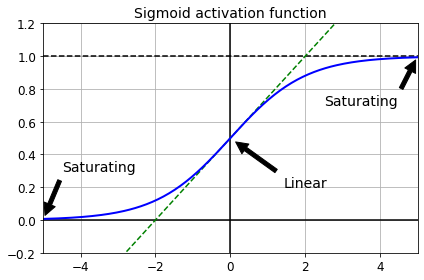

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

### Xavier and He Initialization

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Batch Normalization

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

In [ ]:
#bn1.updates #deprecated

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer has some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Faster Optimizers

### Learning Rate Scheduling

#### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

#### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

#### Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

#### Performance Scheduling

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

#### tf.keras schedulers

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

#### 1Cycle scheduling

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
```

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

## Drop Out

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

### Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.evaluate(X_train_scaled, y_train)

In [ ]:
history = model.fit(X_train_scaled, y_train)

### MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

In [ ]:
np.round(y_probas[:, :1], 2)

In [ ]:
np.round(y_proba[:1], 2)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

## Normalization

### Max norm

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

## Activation function,initializer regularizer and kernel weight constraint

### Leaky ReLU

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Now let's try PReLU:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### ELU

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

## Set up

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Loss Function

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

## Metric

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

In [ ]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

### Streaming metrics (HuberMetric)

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
precision.result()

In [ ]:
precision.variables

In [ ]:
precision.reset_states()

Creating a streaming metric:

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

In [ ]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

In [ ]:
m.variables

In [ ]:
m.reset_states()
m.variables

Let's check that the `HuberMetric` class works well:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

In [ ]:
model.save("my_model_with_a_custom_metric.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [ ]:
model.metrics[-1].threshold

Looks like it works fine! More simply, we could have created the class like this:

In [ ]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

In [ ]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

In [ ]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

In [ ]:
model.metrics[-1].threshold

## Model

In [ ]:
X_new_scaled = X_test_scaled

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

In [ ]:
model.save("my_custom_model.ckpt")

In [ ]:
model = keras.models.load_model("my_custom_model.ckpt")

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5)

We could have defined the model using the sequential API instead:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

## Optimizer

In [ ]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

## Train a model using a custom training loop to tackle the Fashion MNIST dataset

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()
